In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install PyTorch Geometric dependencies for PyTorch 2.0 and CUDA 11.8
# Make sure to adjust versions if needed
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install -q torch-geometric
!pip install -q node2vec networkx python-louvain



In [ ]:
!pip install -q torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.5 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import community as community_louvain

from torch import Tensor
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    ConfusionMatrixDisplay
)
from sklearn.preprocessing import LabelEncoder
from scipy.stats import ttest_ind
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Print versions
import torch_geometric
print("Torch version:", torch.__version__)
print("Torch Geometric version:", torch_geometric.__version__)


Torch version: 2.6.0+cu124
Torch Geometric version: 2.6.1


In [ ]:
# Replace this with the actual folder path in your Drive
folder_path = "/content/drive/MyDrive/elliptic_bitcoin_dataset"  # 🔁 Update accordingly

# Check for CSV files
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
print("Found CSV files:", csv_files)

# Load all CSVs into a dictionary of DataFrames
dataframes = {}

for file in csv_files:
    path = os.path.join(folder_path, file)
    df = pd.read_csv(path)
    dataframes[file] = df
    print(f"\n--- {file} ---")
    print(df.head())


Found CSV files: ['elliptic_txs_classes.csv', 'elliptic_txs_edgelist.csv', 'elliptic_txs_features.csv']

--- elliptic_txs_classes.csv ---
        txId    class
0  230425980  unknown
1    5530458  unknown
2  232022460  unknown
3  232438397        2
4  230460314  unknown

--- elliptic_txs_edgelist.csv ---
       txId1      txId2
0  230425980    5530458
1  232022460  232438397
2  230460314  230459870
3  230333930  230595899
4  232013274  232029206

--- elliptic_txs_features.csv ---
   230425980  1  -0.1714692896288031  -0.18466755143291433  \
0    5530458  1            -0.171484             -0.184668   
1  232022460  1            -0.172107             -0.184668   
2  232438397  1             0.163054              1.963790   
3  230460314  1             1.011523             -0.081127   
4  230459870  1             0.961040             -0.081127   

   -1.2013688016765636  -0.12196959975910057  -0.04387454791734898  \
0            -1.201369             -0.121970             -0.043875   
1  

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [ ]:
RANDOM_STATE = 42
NUM_EPOCHS = 100

In [ ]:
def set_seed_for_torch(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)      # For single-GPU.
        torch.cuda.manual_seed_all(seed)  # For multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def set_seed_for_numpy(seed):
    np.random.seed(seed)

def set_seed_for_random(seed):
    random.seed(seed)

In [ ]:
set_seed_for_torch(RANDOM_STATE)
set_seed_for_numpy(RANDOM_STATE)
set_seed_for_random(RANDOM_STATE)

In [ ]:
def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()


def evaluate(model, data, mask):
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out.argmax(dim=1)

        correct = (pred[mask] == data.y[mask]).sum().item()
        accuracy = correct / mask.sum().item()

        y_true = data.y[mask].cpu().numpy()
        y_pred = pred[mask].cpu().numpy()

        precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

        metrics = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }

    return metrics

def predict(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out.argmax(dim=1)
    return pred

def predict_probabilities(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data)
        probabilities = torch.exp(out)
    return probabilities

In [ ]:
def train_gnn(num_epochs, data, model, optimizer, criterion):

    train_losses = []
    train_accuracies = []
    train_precisions = []
    train_recalls = []
    train_f1_scores = []

    val_accuracies = []
    val_precisions = []
    val_recalls = []
    val_f1_scores = []

    # ----- #
    # Train #
    # ----- #

    for epoch in range(1, num_epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask],
                         data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # --- Calculate training metrics ---
        pred_train = out[data.train_mask].argmax(dim=1)
        correct_train = (pred_train == data.y[data.train_mask]).sum()
        train_acc = int(correct_train) / int(data.train_mask.sum())
        train_accuracies.append(train_acc)

        y_true_train = data.y[data.train_mask].cpu().numpy()
        y_pred_train = pred_train.cpu().numpy()

        train_prec = precision_score(y_true_train, y_pred_train, average='weighted', zero_division=0)
        train_rec = recall_score(y_true_train, y_pred_train, average='weighted', zero_division=0)
        train_f1 = f1_score(y_true_train, y_pred_train, average='weighted', zero_division=0)

        train_precisions.append(train_prec)
        train_recalls.append(train_rec)
        train_f1_scores.append(train_f1)
        train_losses.append(loss.item())

        # --- Validate and calculate validation metrics ---
        model.eval()
        with torch.no_grad():
            out = model(data)
            pred_val = out[data.val_mask].argmax(dim=1)
            correct_val = (pred_val == data.y[data.val_mask]).sum()
            val_acc = int(correct_val) / int(data.val_mask.sum())
            val_accuracies.append(val_acc)

            y_true_val = data.y[data.val_mask].cpu().numpy()
            y_pred_val = pred_val.cpu().numpy()

            val_prec = precision_score(y_true_val, y_pred_val, average='weighted', zero_division=0)
            val_rec = recall_score(y_true_val, y_pred_val, average='weighted', zero_division=0)
            val_f1 = f1_score(y_true_val, y_pred_val, average='weighted', zero_division=0)

            val_precisions.append(val_prec)
            val_recalls.append(val_rec)
            val_f1_scores.append(val_f1)

        if epoch % 10 == 0:
            print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, Train - Acc: {train_acc:.4f} - Prec: {train_prec:.4f} - Rec: {train_rec:.4f} - F1: {train_f1:.4f}')
            print(f'                         Val   - Acc: {val_acc:.4f} - Prec: {val_prec:.4f} - Rec: {val_rec:.4f} - F1: {val_f1:.4f}')

    return {
        'train': {
            'losses': train_losses,
            'accuracies': train_accuracies,
            'precisions': train_precisions,
            'recalls': train_recalls,
            'f1_scores': train_f1_scores,
        },
        'val': {
            'accuracies': val_accuracies,
            'precisions': val_precisions,
            'recalls': val_recalls,
            'f1_scores': val_f1_scores,
        }
    }

In [ ]:
def plot_train_val_test_metrics(train_val_metrics, test_metrics, num_epochs):
    plt.figure(figsize=(10, 6))

    # --- Accuracy ----
    plt.subplot(2, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_val_metrics['train']['accuracies'], color='C0', linewidth=1.0, label='Training')
    plt.plot(range(1, num_epochs + 1), train_val_metrics['val']['accuracies'], color='C1', linewidth=1.0, label='Validation', linestyle=':')
    plt.axhline(y=test_metrics['accuracy'], color='C2', linewidth=0.5, linestyle='--', label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(fontsize=8)
    plt.title('Accuracy')

    # --- Precision ---
    plt.subplot(2, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_val_metrics['train']['precisions'], color='C0', linewidth=1.0, label='Training')
    plt.plot(range(1, num_epochs + 1), train_val_metrics['val']['precisions'], color='C1', linewidth=1.0, label='Validation', linestyle=':')
    plt.axhline(y=test_metrics['precision'], color='C2', linewidth=0.5, linestyle='--', label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend(fontsize=8)
    plt.title('Precision')

    # --- Recall ---
    plt.subplot(2, 2, 3)
    plt.plot(range(1, num_epochs + 1), train_val_metrics['train']['recalls'], color='C0', linewidth=1.0, label='Training')
    plt.plot(range(1, num_epochs + 1), train_val_metrics['val']['recalls'], color='C1', linewidth=1.0, label='Validation', linestyle=':')
    plt.axhline(y=test_metrics['recall'], color='C2', linewidth=0.5, linestyle='--', label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend(fontsize=8)
    plt.title('Recall')

    # --- F1-Score ---
    plt.subplot(2, 2, 4)
    plt.plot(range(1, num_epochs + 1), train_val_metrics['train']['f1_scores'], linewidth=1.0, color='C0', label='Training')
    plt.plot(range(1, num_epochs + 1), train_val_metrics['val']['f1_scores'], linewidth=1.0, color='C1', label='Validation', linestyle=':')
    plt.axhline(y=test_metrics['f1_score'], color='C2', linewidth=0.5, linestyle='--', label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('F1-Score')
    plt.legend(fontsize=8)
    plt.title('F1-Score')

    plt.tight_layout()
    plt.show()

In [ ]:
elliptic_txs_features = pd.read_csv('/content/drive/MyDrive/elliptic_bitcoin_dataset/elliptic_txs_features.csv', header=None)
elliptic_txs_classes = pd.read_csv('/content/drive/MyDrive/elliptic_bitcoin_dataset/elliptic_txs_classes.csv')
elliptic_txs_edgelist = pd.read_csv('/content/drive/MyDrive/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv')

elliptic_txs_features.columns = ['txId'] + [f'V{i}' for i in range(1, 167)]

print(f"""Shapes
{4*' '}Features : {elliptic_txs_features.shape[0]:8,} (rows)  {elliptic_txs_features.shape[1]:4,} (cols)
{4*' '}Classes  : {elliptic_txs_classes.shape[0]:8,} (rows)  {elliptic_txs_classes.shape[1]:4,} (cols)
{4*' '}Edgelist : {elliptic_txs_edgelist.shape[0]:8,} (rows)  {elliptic_txs_edgelist.shape[1]:4,} (cols)
""")

Shapes
    Features :  203,769 (rows)   167 (cols)
    Classes  :  203,769 (rows)     2 (cols)
    Edgelist :  234,355 (rows)     2 (cols)



In [ ]:
elliptic_txs_features.head(3)

,txId,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.12197,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.12197,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.12197,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792


In [ ]:
elliptic_txs_classes.head(3)

,txId,class
0,230425980,unknown
1,5530458,unknown
2,232022460,unknown


In [ ]:
elliptic_txs_edgelist.head(3)

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870


In [ ]:
elliptic_txs_classes['class_mapped'] = elliptic_txs_classes['class'].replace({'1': 'illicit', '2': 'licit'})

percentage_distribution = round(100 * elliptic_txs_classes['class_mapped'].value_counts(normalize=True), 2)
class_counts = elliptic_txs_classes['class_mapped'].value_counts()

emoji_mapping = {'licit': '✅', 'illicit': '❌', 'unknown': '🤷'}
elliptic_txs_classes['emoji'] = elliptic_txs_classes['class_mapped'].map(emoji_mapping)

classes_df = pd.DataFrame({
    'Class Mapped': elliptic_txs_classes['class_mapped'].unique(),
    'Class Raw': elliptic_txs_classes['class'].unique(),
    'Counts': class_counts.values,
    'Percentage': percentage_distribution.values,
    'Emoji': [emoji_mapping[class_label] for class_label in elliptic_txs_classes['class_mapped'].unique()]
})
classes_df

,Class Mapped,Class Raw,Counts,Percentage,Emoji
0,unknown,unknown,157205,77.15,🤷
1,licit,2,42019,20.62,✅
2,illicit,1,4545,2.23,❌


In [ ]:
num_nodes = elliptic_txs_features.shape[0]
num_edges = elliptic_txs_edgelist.shape[0]

print(f"Number of nodes: {num_nodes:,}")
print(f"Number of edges: {num_edges:,}")

Number of nodes: 203,769
Number of edges: 234,355


In [ ]:
G = nx.from_pandas_edgelist(elliptic_txs_edgelist, 'txId1', 'txId2')

In [ ]:
classes_sampled = elliptic_txs_classes.groupby('class_mapped').sample(frac=0.05, random_state=RANDOM_STATE)
txIds_sampled = classes_sampled['txId']

# Filter elliptic_txs_edgelist based on the sampled txIds
edgelist_sampled = elliptic_txs_edgelist[
    elliptic_txs_edgelist['txId1'].isin(txIds_sampled) | elliptic_txs_edgelist['txId2'].isin(txIds_sampled)
]

# Filter elliptic_txs_features based on the sampled txIds
features_sampled = elliptic_txs_features[elliptic_txs_features['txId'].isin(txIds_sampled)]

print(f"Sampled Classes:\n{classes_sampled['class_mapped'].value_counts()}\n")
print(f"Sampled Edgelist: {edgelist_sampled.shape[0]:,}")
print(f"Sampled Features: {features_sampled.shape[0]:,}")

Sampled Classes:
class_mapped
unknown    7860
licit      2101
illicit     227
Name: count, dtype: int64

Sampled Edgelist: 23,051
Sampled Features: 10,188


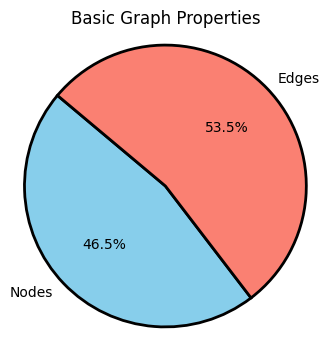

In [ ]:
plt.figure(figsize=(4, 4))
sizes = [num_nodes, num_edges]
labels = ['Nodes', 'Edges']
colors = ['skyblue', 'salmon']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140,
        wedgeprops = {'edgecolor' : 'black',
                      'linewidth': 2,
                      'antialiased': True})
plt.title('Basic Graph Properties')
plt.axis('equal')
plt.show()

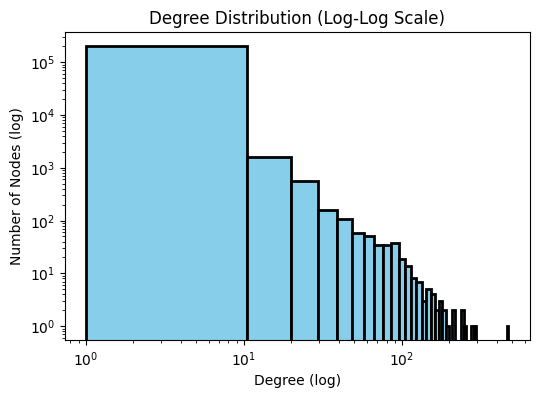

In [ ]:
plt.figure(figsize=(6, 4))
degrees = [G.degree(n) for n in G.nodes()]
plt.hist(degrees, bins=50, log=True, color='skyblue', edgecolor='black', linewidth=2.0)
plt.xscale('log')
plt.yscale('log')
plt.title('Degree Distribution (Log-Log Scale)')
plt.xlabel('Degree (log)')
plt.ylabel('Number of Nodes (log)')
plt.show()

Number of nodes: 10,188
Number of edges: 23,051


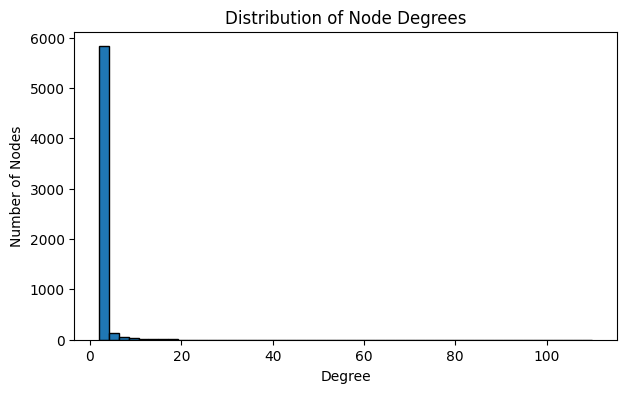

In [ ]:
num_nodes = features_sampled.shape[0]
num_edges = edgelist_sampled.shape[0]

print(f"Number of nodes: {num_nodes:,}")
print(f"Number of edges: {num_edges:,}")

# Distribution of node degrees
plt.figure(figsize=(7, 4))

node_degrees = edgelist_sampled['txId1'].value_counts() + edgelist_sampled['txId2'].value_counts()
node_degrees.hist(bins=50, edgecolor='black')
plt.title('Distribution of Node Degrees')
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')
plt.grid(False)
plt.show()

In [ ]:
G = nx.from_pandas_edgelist(edgelist_sampled, 'txId1', 'txId2')

Number of connected components: 7297
Giant component - Number of nodes: 400
Giant component - Number of edges: 431


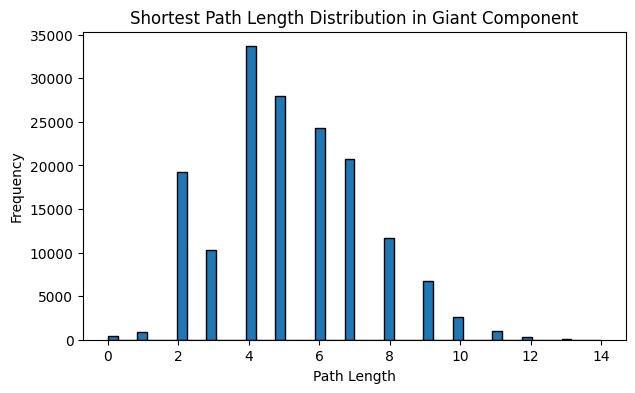

In [ ]:
num_connected_components = nx.number_connected_components(G)
print(f"Number of connected components: {num_connected_components}")

# --- Giant component analysis ---
giant_component = max(nx.connected_components(G), key=len)
G_giant = G.subgraph(giant_component)

print(f"Giant component - Number of nodes: {G_giant.number_of_nodes():,}")
print(f"Giant component - Number of edges: {G_giant.number_of_edges():,}")


# --------------------------------------------------------- #
# Shortest paths length distribution in the giant component #
# --------------------------------------------------------- #
path_lengths = dict(nx.shortest_path_length(G_giant))
path_lengths_values = [length for target_lengths in path_lengths.values() for length in target_lengths.values()]

plt.figure(figsize=(7, 4))
plt.hist(path_lengths_values, bins=50, edgecolor='black')
plt.title('Shortest Path Length Distribution in Giant Component')
plt.xlabel('Path Length')
plt.ylabel('Frequency')
plt.show()

In [ ]:
import matplotlib as mpl


Top 10 nodes by degree centrality:
        Node  Degree Centrality
0   22837965           0.275689
1   22837835           0.192982
2  279199578           0.030075
3    3807285           0.027569
4  279187194           0.027569
5   22837973           0.022556
6   90716926           0.022556
7    8128388           0.022556
8   22837808           0.020050
9   22838007           0.020050


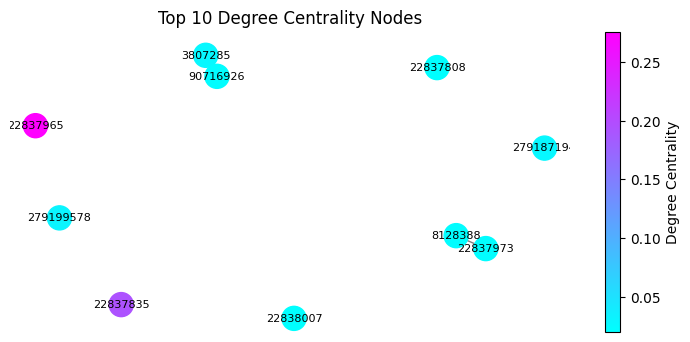

In [ ]:
import matplotlib as mpl

degree_centrality = nx.degree_centrality(G_giant)
top_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
df_top_degree_centrality = pd.DataFrame(top_degree_centrality, columns=['Node', 'Degree Centrality'])

print("Top 10 nodes by degree centrality:")
print("==================================")
print(df_top_degree_centrality)

top_nodes_by_ = df_top_degree_centrality['Node'].tolist()
subgraph = G_giant.subgraph(top_nodes_by_)
node_color = [degree_centrality[node] for node in subgraph.nodes()]
norm = mpl.colors.Normalize(vmin=min(node_color), vmax=max(node_color))
node_color_normalized = [norm(value) for value in node_color]
cmap = plt.cm.cool

# -------- #
# Plotting #
# -------- #
plt.figure(figsize=(7, 3))
pos = nx.spring_layout(subgraph, seed=42)  # Fix layout for consistency
nodes = nx.draw(
    subgraph, pos=pos, with_labels=True, node_size=300, edge_color='gray', font_size=8,
    node_color=node_color_normalized, cmap=cmap
)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # required for colorbar in matplotlib >= 3.1
plt.colorbar(sm, ax=plt.gca(), label='Degree Centrality')  # ✅ This fixes the ValueError
plt.title('Top 10 Degree Centrality Nodes')
plt.show()


Top 10 nodes by betweenness centrality:
        Node  Betweenness Centrality
0   22837835                0.553959
1   22837965                0.491607
2   90716926                0.166458
3   22837784                0.165590
4  279187194                0.164591
5    3807285                0.144993
6    3097782                0.113509
7    8128388                0.103709
8    1435388                0.092219
9   21296808                0.086872


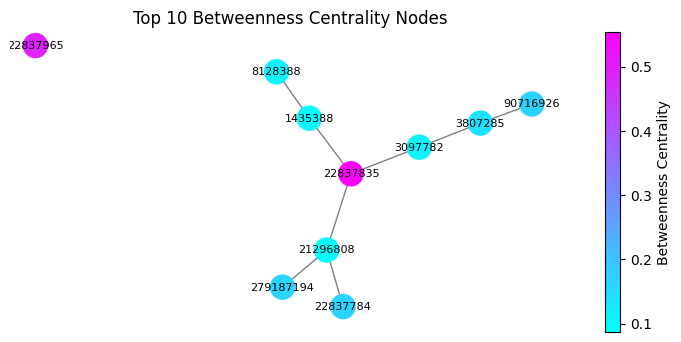

In [ ]:
import matplotlib as mpl

# Compute betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G_giant)
top_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
df_top_betweenness_centrality = pd.DataFrame(top_betweenness_centrality, columns=['Node', 'Betweenness Centrality'])

# Print the top 10
print("Top 10 nodes by betweenness centrality:")
print("=======================================")
print(df_top_betweenness_centrality)

# Create subgraph of top nodes
top_nodes_by_ = df_top_betweenness_centrality['Node'].tolist()
subgraph = G_giant.subgraph(top_nodes_by_)

# Normalize node colors
node_color = [betweenness_centrality[node] for node in subgraph.nodes()]
norm = mpl.colors.Normalize(vmin=min(node_color), vmax=max(node_color))
node_color_normalized = [norm(value) for value in node_color]
cmap = plt.cm.cool

# -------- #
# Plotting #
# -------- #
plt.figure(figsize=(7, 3))
pos = nx.spring_layout(subgraph, seed=42)  # Fix layout for consistency

nx.draw(
    subgraph, pos=pos, with_labels=True, node_size=300, edge_color='gray', font_size=8,
    node_color=node_color_normalized, cmap=cmap
)

# Add colorbar correctly
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # Required to avoid deprecation warning
plt.colorbar(sm, ax=plt.gca(), label='Betweenness Centrality')

plt.title('Top 10 Betweenness Centrality Nodes')
plt.show()


Top 10 nodes by closeness centrality:
        Node  Closeness Centrality
0   22837835              0.317928
1   22837965              0.293814
2    2203811              0.290605
3    1805107              0.285817
4   11447640              0.285817
5    2205152              0.285817
6    1367537              0.285817
7    1437191              0.285817
8   21296808              0.274038
9  279187194              0.271613


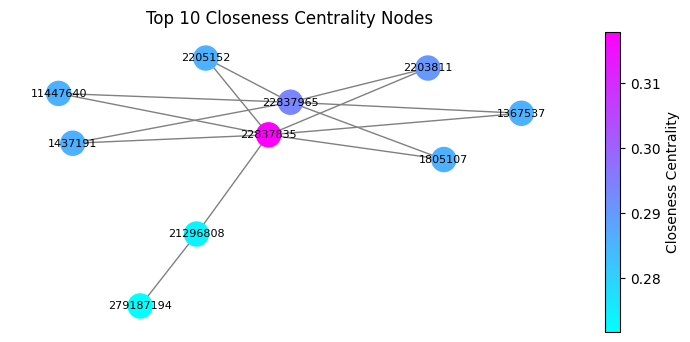

In [ ]:
import matplotlib as mpl

# Compute closeness centrality
closeness_centrality = nx.closeness_centrality(G_giant)
top_closeness_centrality = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
df_top_closeness_centrality = pd.DataFrame(top_closeness_centrality, columns=['Node', 'Closeness Centrality'])

# Display top 10 nodes
print("Top 10 nodes by closeness centrality:")
print("=====================================")
print(df_top_closeness_centrality)

# Create subgraph of top nodes
top_nodes_by_closeness = df_top_closeness_centrality['Node'].tolist()
subgraph = G_giant.subgraph(top_nodes_by_closeness)

# Normalize node colors
node_color = [closeness_centrality[node] for node in subgraph.nodes()]
norm = mpl.colors.Normalize(vmin=min(node_color), vmax=max(node_color))
node_color_normalized = [norm(value) for value in node_color]
cmap = plt.cm.cool

# -------- #
# Plotting #
# -------- #
plt.figure(figsize=(7, 3))
pos = nx.spring_layout(subgraph, seed=42)  # Consistent layout

nx.draw(
    subgraph, pos=pos, with_labels=True, node_size=300, edge_color='gray', font_size=8,
    node_color=node_color_normalized, cmap=cmap
)

# Correct colorbar usage
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
plt.colorbar(sm, ax=plt.gca(), label='Closeness Centrality')

plt.title('Top 10 Closeness Centrality Nodes')
plt.show()


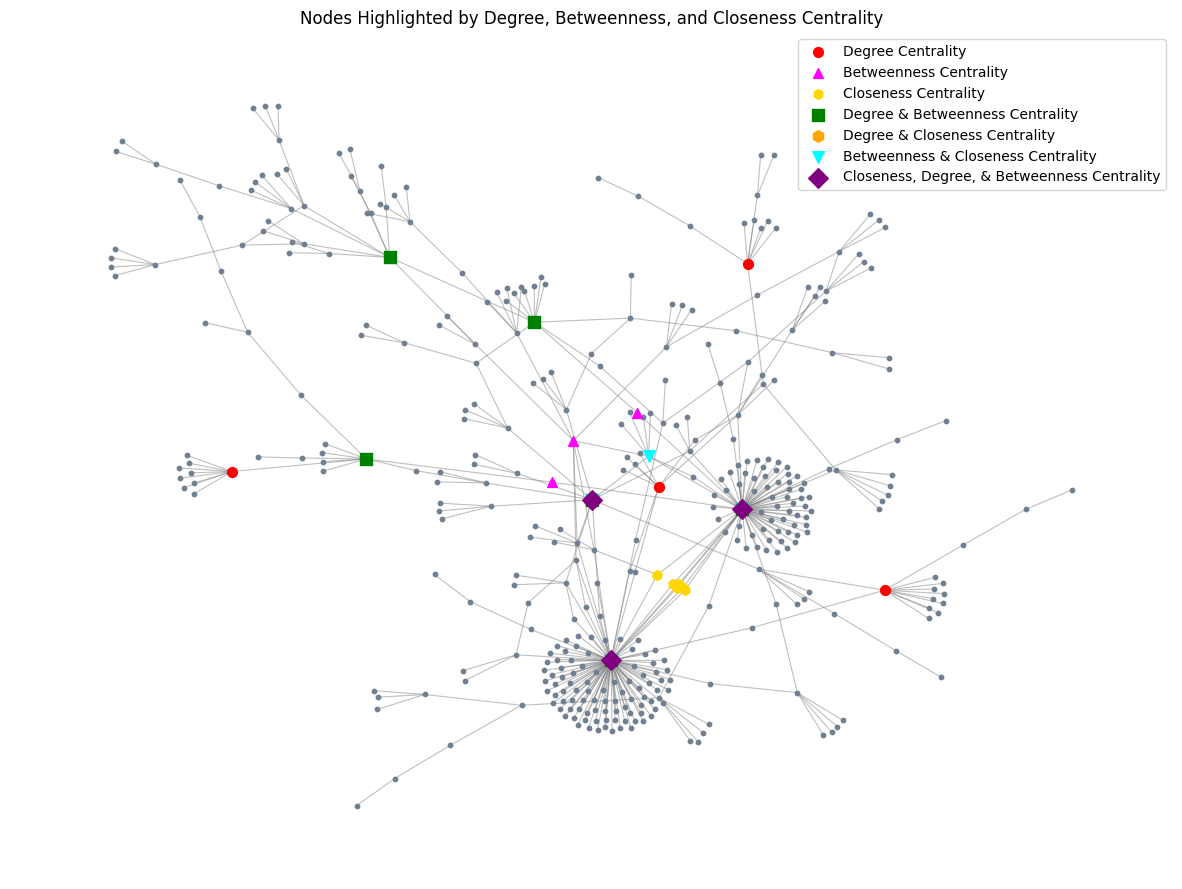

In [ ]:
# --------- #
# Preparing #
# --------- #

# Identify nodes that are top in each centrality measure and their combinations.
top_nodes_degree = set([node for node, _ in top_degree_centrality])
top_nodes_betweenness = set([node for node, _ in top_betweenness_centrality])
top_nodes_closeness = set([node for node, _ in top_closeness_centrality])

top_nodes_both = top_nodes_degree.intersection(top_nodes_betweenness)
top_nodes_closeness_and_degree = top_nodes_closeness.intersection(top_nodes_degree)
top_nodes_closeness_and_betweenness = top_nodes_closeness.intersection(top_nodes_betweenness)
top_nodes_all_three = top_nodes_closeness.intersection(top_nodes_degree).intersection(top_nodes_betweenness)

# Assign colors and shapes based on centrality measures.
node_color = []
node_shape = []

for node in G_giant.nodes():
    if node in top_nodes_all_three:
        node_color.append('purple')
        node_shape.append('D')
    elif node in top_nodes_closeness_and_degree:
        node_color.append('orange')
        node_shape.append('h')
    elif node in top_nodes_closeness_and_betweenness:
        node_color.append('cyan')
        node_shape.append('v')
    elif node in top_nodes_both:
        node_color.append('green')
        node_shape.append('s')
    elif node in top_nodes_degree:
        node_color.append('red')
        node_shape.append('o')
    elif node in top_nodes_betweenness:
        node_color.append('magenta')
        node_shape.append('^')
    elif node in top_nodes_closeness:
        node_color.append('yellow')
        node_shape.append('h')
    else:
        node_color.append('slategrey')
        node_shape.append('o')

# -------- #
# Plotting #
# -------- #

plt.figure(figsize=(15, 11))

pos = nx.spring_layout(G_giant)
# Draw all nodes first.
nx.draw_networkx_nodes(G_giant, pos, node_color='slategrey', node_size=10)

# Draw nodes with specific centrality measures.
nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_degree - top_nodes_both - top_nodes_closeness_and_degree),
                       node_color='red', node_size=50, node_shape='o',
                       label='Degree Centrality')
nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_betweenness - top_nodes_both - top_nodes_closeness_and_betweenness),
                       node_color='magenta', node_size=50, node_shape='^',
                       label='Betweenness Centrality')
nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_closeness - top_nodes_closeness_and_degree - top_nodes_closeness_and_betweenness),
                       node_color='gold', node_size=50, node_shape='h',
                       label='Closeness Centrality')
nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_both),
                       node_color='green', node_size=80, node_shape='s',
                       label='Degree & Betweenness Centrality')
nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_closeness_and_degree),
                       node_color='orange', node_size=70, node_shape='h',
                       label='Degree & Closeness Centrality')
nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_closeness_and_betweenness),
                       node_color='cyan', node_size=70, node_shape='v',
                       label='Betweenness & Closeness Centrality')
nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_all_three),
                       node_color='purple', node_size=100, node_shape='D',
                       label='Closeness, Degree, & Betweenness Centrality')

# Draw edges.
nx.draw_networkx_edges(G_giant, pos, width=0.8, edge_color='gray', alpha=0.5)

plt.axis('off')
plt.title('Nodes Highlighted by Degree, Betweenness, and Closeness Centrality')
plt.legend(scatterpoints=1)
plt.show()

In [ ]:
illicit_nodes = classes_sampled[classes_sampled['class_mapped'] == 'illicit']['txId']
licit_nodes = classes_sampled[classes_sampled['class_mapped'] == 'licit']['txId']

G_illicit = G.subgraph(illicit_nodes)
G_licit = G.subgraph(licit_nodes)

In [ ]:
classes_df

,Class Mapped,Class Raw,Counts,Percentage,Emoji
0,unknown,unknown,157205,77.15,🤷
1,licit,2,42019,20.62,✅
2,illicit,1,4545,2.23,❌


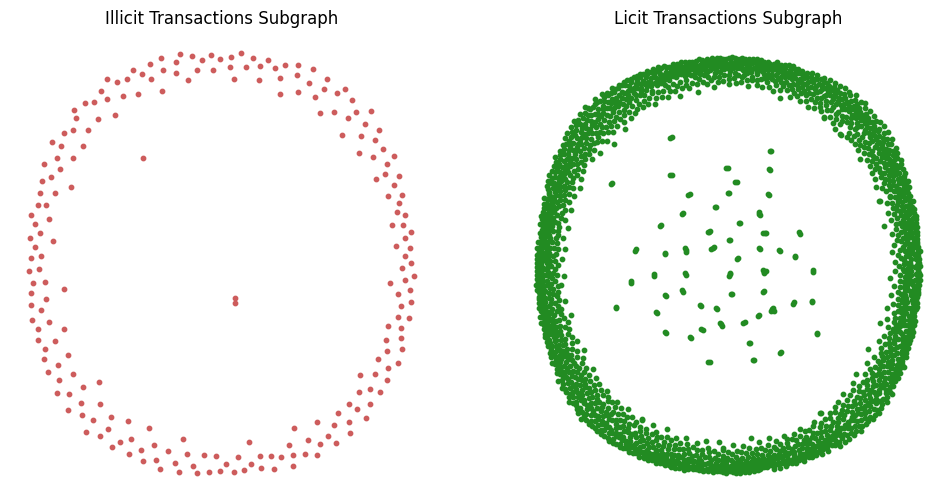

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
nx.draw(G_illicit, with_labels=False, node_size=10, node_color='indianred', edge_color='black')
plt.title('Illicit Transactions Subgraph')

plt.subplot(1, 2, 2)
nx.draw(G_licit, with_labels=False, node_size=10, node_color='forestgreen', edge_color='black')
plt.title('Licit Transactions Subgraph')

plt.show()

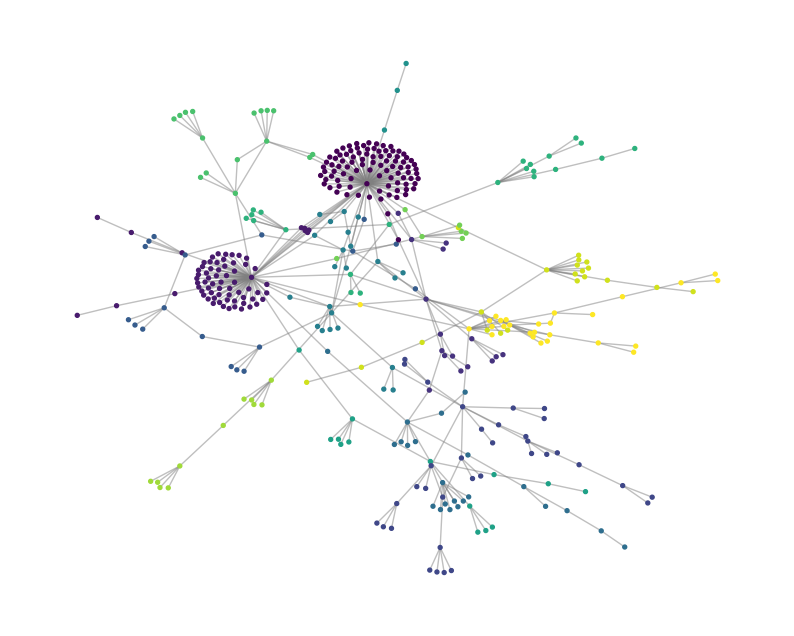

In [ ]:
partition = community_louvain.best_partition(G_giant)

# Draw graph.
plt.figure(figsize=(10, 8))

pos = nx.spring_layout(G_giant)
cmap = plt.get_cmap('viridis')
nx.draw_networkx_nodes(G_giant, pos, node_color=list(partition.values()), node_size=8, cmap=cmap)
nx.draw_networkx_edges(G_giant, pos, alpha=0.5, edge_color='grey')
plt.axis('off')

plt.show()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
metrics_per_gnn = {
    'gcn': {
        'val': {
            'precisions': [],
            'probas': [],
        },
        'test': {
            'licit': {
                'probas': []
            },
            'illicit': {
                'probas': []
            },
        }
    },
    'gat': {
        'val': {
            'precisions': [],
            'probas': [],
        },
        'test': {
            'licit': {
                'probas': []
            },
            'illicit': {
                'probas': []
            },
        }
    },
    'gin': {
        'val': {
            'precisions': [],
            'probas': [],
        },
        'test': {
            'licit': {
                'probas': []
            },
            'illicit': {
                'probas': []
            },
        }
    }
}

In [ ]:
num_edges = elliptic_txs_edgelist.shape[0]
num_nodes = elliptic_txs_features.shape[0]

print(f'Number of edges in the graph: {num_edges:8,}')
print(f'Number of nodes in the graph: {num_nodes:8,}')

Number of edges in the graph:  234,355
Number of nodes in the graph:  203,769


In [ ]:
tx_id_mapping = {tx_id: idx for idx, tx_id in enumerate(elliptic_txs_features['txId'])}

edges_with_features = elliptic_txs_edgelist[elliptic_txs_edgelist['txId1'].isin(list(tx_id_mapping.keys()))\
                                          & elliptic_txs_edgelist['txId2'].isin(list(tx_id_mapping.keys()))]

edges_with_features['Id1'] = edges_with_features['txId1'].map(tx_id_mapping)
edges_with_features['Id2'] = edges_with_features['txId2'].map(tx_id_mapping)

edges_with_features

,txId1,txId2,Id1,Id2
0,230425980,5530458,0,1
1,232022460,232438397,2,3
2,230460314,230459870,4,5
3,230333930,230595899,6,7
4,232013274,232029206,8,9
...,...,...,...,...
234350,158365409,157930723,203602,201430
234351,188708874,188708879,203603,203099
234352,157659064,157659046,201921,202042
234353,87414554,106877725,201480,201368


In [ ]:
edge_index = torch.tensor(edges_with_features[['Id1', 'Id2']].values.T, dtype=torch.long)
edge_index

tensor([[     0,      2,      4,  ..., 201921, 201480, 201954],
        [     1,      3,      5,  ..., 202042, 201368, 201756]])

In [ ]:
node_features = torch.tensor(elliptic_txs_features.drop(columns=['txId']).values,
                             dtype=torch.float)
print(node_features.shape)
node_features

torch.Size([203769, 166])


tensor([[ 1.0000e+00, -1.7147e-01, -1.8467e-01,  ..., -9.7524e-02,
         -1.2061e-01, -1.1979e-01],
        [ 1.0000e+00, -1.7148e-01, -1.8467e-01,  ..., -9.7524e-02,
         -1.2061e-01, -1.1979e-01],
        [ 1.0000e+00, -1.7211e-01, -1.8467e-01,  ..., -1.8367e-01,
         -1.2061e-01, -1.1979e-01],
        ...,
        [ 4.9000e+01, -1.7201e-01, -7.8182e-02,  ..., -9.7524e-02,
         -1.2061e-01, -1.1979e-01],
        [ 4.9000e+01, -1.7284e-01, -1.7662e-01,  ..., -1.4060e-01,
          1.5197e+00,  1.5214e+00],
        [ 4.9000e+01, -1.2037e-02, -1.3228e-01,  ..., -1.4060e-01,
          1.5197e+00,  1.5214e+00]])

In [ ]:
elliptic_txs_classes['class'].value_counts()

,count
class,
unknown,157205
2,42019
1,4545


In [ ]:
le = LabelEncoder()
class_labels = le.fit_transform(elliptic_txs_classes['class'])
node_labels = torch.tensor(class_labels, dtype=torch.long)
original_labels = le.inverse_transform(class_labels)

print(original_labels)
print(class_labels)
print(node_labels)

['unknown' 'unknown' 'unknown' ... '1' 'unknown' 'unknown']
[2 2 2 ... 0 2 2]
tensor([2, 2, 2,  ..., 0, 2, 2])


In [ ]:
print(le.inverse_transform([0])) # illicit
print(le.inverse_transform([1])) # licit
print(le.inverse_transform([2])) # unknown

['1']
['2']
['unknown']


In [ ]:
data = Data(x=node_features,
            edge_index=edge_index,
            y=node_labels)

# Move data to GPU.
data = data.to(device)

In [ ]:
known_mask   = (data.y == 0) | (data.y == 1)  # Only nodes with known labels licit or illicit
unknown_mask = data.y == 2                    # Nodes with unknown labels

In [ ]:
num_known_nodes = known_mask.sum().item()
permutations = torch.randperm(num_known_nodes)
train_size = int(0.8 * num_known_nodes)
val_size = int(0.1 * num_known_nodes)
test_size = num_known_nodes - train_size - val_size

total = np.sum([train_size, val_size, test_size])

print(f"""Number of observations per split
    Training   : {train_size:10,} ({100*train_size/total:0.2f} %)
    Validation : {val_size:10,} ({100*val_size/total:0.2f} %)
    Testing    : {test_size:10,} ({100*test_size/total:0.2f} %)
""")

Number of observations per split
    Training   :     37,251 (80.00 %)
    Validation :      4,656 (10.00 %)
    Testing    :      4,657 (10.00 %)



In [ ]:
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)

train_indices = known_mask.nonzero(as_tuple=True)[0][permutations[:train_size]]
val_indices = known_mask.nonzero(as_tuple=True)[0][permutations[train_size:train_size + val_size]]
test_indices = known_mask.nonzero(as_tuple=True)[0][permutations[train_size + val_size:]]

data.train_mask[train_indices] = True
data.val_mask[val_indices] = True
data.test_mask[test_indices] = True

data.train_mask

tensor([False, False, False,  ...,  True, False, False])

In [ ]:
train_licit, train_illicit = (data.y[data.train_mask] == 1).sum().item(), (data.y[data.train_mask] == 0).sum().item()
val_licit, val_illicit = (data.y[data.val_mask] == 1).sum().item(), (data.y[data.val_mask] == 0).sum().item()
test_licit, test_illicit = (data.y[data.test_mask] == 1).sum().item(), (data.y[data.test_mask] == 0).sum().item()

# Calculate total counts.
train_total = train_licit + train_illicit
val_total = val_licit + val_illicit
test_total = test_licit + test_illicit

# Calculate percentages.
train_licit_pct = (train_licit / train_total) * 100
train_illicit_pct = (train_illicit / train_total) * 100
val_licit_pct = (val_licit / val_total) * 100
val_illicit_pct = (val_illicit / val_total) * 100
test_licit_pct = (test_licit / test_total) * 100
test_illicit_pct = (test_illicit / test_total) * 100

pd.DataFrame({
    'Set': ['Training', 'Validation', 'Testing'],
    'Total Count': [train_total, val_total, test_total],
    'Licit': [train_licit, val_licit, test_licit],
    'Licit (%)': [train_licit_pct, val_licit_pct, test_licit_pct],
    'Illicit': [train_illicit, val_illicit, test_illicit],
    'Illicit (%)': [train_illicit_pct, val_illicit_pct, test_illicit_pct]
})

,Set,Total Count,Licit,Licit (%),Illicit,Illicit (%)
0,Training,37251,33649,90.330461,3602,9.669539
1,Validation,4656,4148,89.089347,508,10.910653
2,Testing,4657,4222,90.659223,435,9.340777


In [ ]:
mapped_classes = np.array(['illicit', 'licit'])

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


# ---------- #
# Initialize #
# ---------- #

model = GCN(num_node_features=data.num_features, num_classes=len(le.classes_)).to(device)
optimizer = torch.optim.Adam(model.parameters(),
                             lr=0.01,
                             weight_decay=0.0005)
criterion = torch.nn.CrossEntropyLoss()  # Since we have a multiclass classification problem.

data = data.to(device)

In [ ]:
train_val_metrics = train_gnn(NUM_EPOCHS,
                              data,
                              model,
                              optimizer,
                              criterion)

metrics_per_gnn['gcn']['val']['precisions'] = train_val_metrics['val']['precisions']

Epoch 010, Loss: 0.4143, Train - Acc: 0.8988 - Prec: 0.8662 - Rec: 0.8988 - F1: 0.8737
                         Val   - Acc: 0.8915 - Prec: 0.8586 - Rec: 0.8915 - F1: 0.8595
Epoch 020, Loss: 0.3295, Train - Acc: 0.9047 - Prec: 0.8763 - Rec: 0.9047 - F1: 0.8674
                         Val   - Acc: 0.8950 - Prec: 0.8743 - Rec: 0.8950 - F1: 0.8548
Epoch 030, Loss: 0.2562, Train - Acc: 0.8915 - Prec: 0.8907 - Rec: 0.8915 - F1: 0.8911
                         Val   - Acc: 0.8877 - Prec: 0.8846 - Rec: 0.8877 - F1: 0.8861
Epoch 040, Loss: 0.2294, Train - Acc: 0.9072 - Prec: 0.8893 - Rec: 0.9072 - F1: 0.8937
                         Val   - Acc: 0.9003 - Prec: 0.8810 - Rec: 0.9003 - F1: 0.8818
Epoch 050, Loss: 0.2182, Train - Acc: 0.9073 - Prec: 0.8846 - Rec: 0.9073 - F1: 0.8751
                         Val   - Acc: 0.8969 - Prec: 0.8764 - Rec: 0.8969 - F1: 0.8625
Epoch 060, Loss: 0.2058, Train - Acc: 0.9190 - Prec: 0.9073 - Rec: 0.9190 - F1: 0.9002
                         Val   - Acc: 0.912

In [ ]:
# -------- #
# Evaluate #
# -------- #

model.eval()
with torch.no_grad():

    test_metrics = evaluate(model, data, data.test_mask)
    test_acc = test_metrics.get('accuracy')
    test_prec = test_metrics.get('precision')
    test_rec = test_metrics.get('recall')
    test_f1 = test_metrics.get('f1_score')

    print(f'Test Acc: {test_acc:.4f} - Prec: {test_prec:.4f} - Rec: {test_rec:.4f} - F1: {test_f1:.4f}')

Test Acc: 0.9431 - Prec: 0.9394 - Rec: 0.9431 - F1: 0.9353


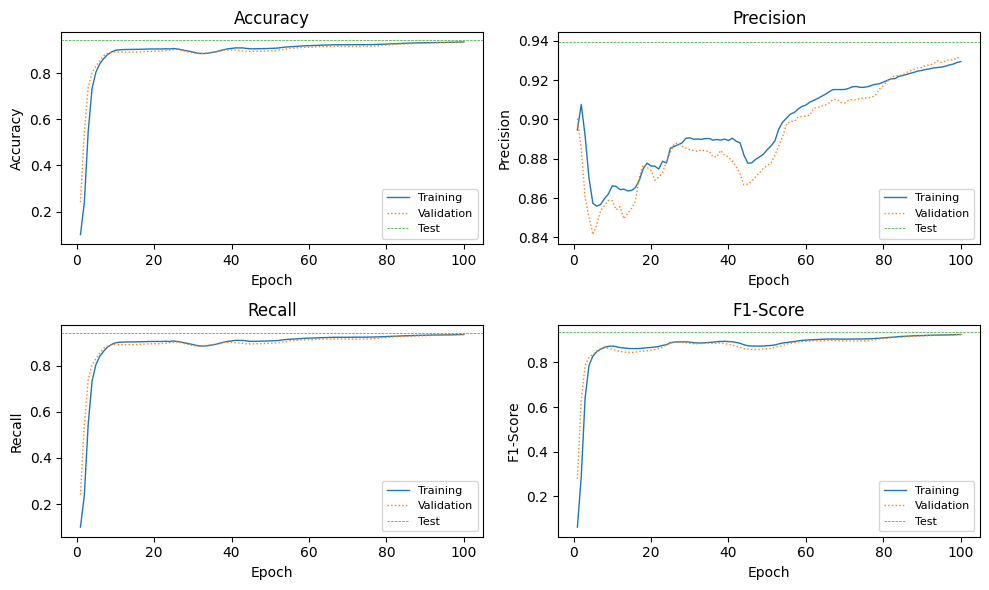

In [ ]:
plot_train_val_test_metrics(train_val_metrics, test_metrics, NUM_EPOCHS)

In [ ]:
train_pred = predict(model, data)[data.train_mask]
test_pred = predict(model, data)[data.test_mask]

In [ ]:
print(le.inverse_transform([0])) # illicit
print(le.inverse_transform([1])) # licit
print(le.inverse_transform([2])) # unknown

['1']
['2']
['unknown']


In [ ]:
print("Classification Report")
print("=====================\n")

# Train.
y_true_train = data.y[data.train_mask].cpu().numpy()
y_pred_train = train_pred.cpu().numpy()

report_train = classification_report(y_true_train, y_pred_train, target_names=mapped_classes)

print(f"{4*' '}TRAIN")
print("---------")
print(report_train)

# Test.
y_true_test = data.y[data.test_mask].cpu().numpy()
y_pred_test = test_pred.cpu().numpy()

report_test = classification_report(y_true_test, y_pred_test, target_names=mapped_classes)

print(f"{4*' '}TEST")
print("--------")
print(report_test)

Classification Report

    TRAIN
---------
              precision    recall  f1-score   support

     illicit       0.82      0.43      0.56      3602
       licit       0.94      0.99      0.97     33649

    accuracy                           0.94     37251
   macro avg       0.88      0.71      0.76     37251
weighted avg       0.93      0.94      0.93     37251

    TEST
--------
              precision    recall  f1-score   support

     illicit       0.86      0.47      0.61       435
       licit       0.95      0.99      0.97      4222

    accuracy                           0.94      4657
   macro avg       0.90      0.73      0.79      4657
weighted avg       0.94      0.94      0.94      4657



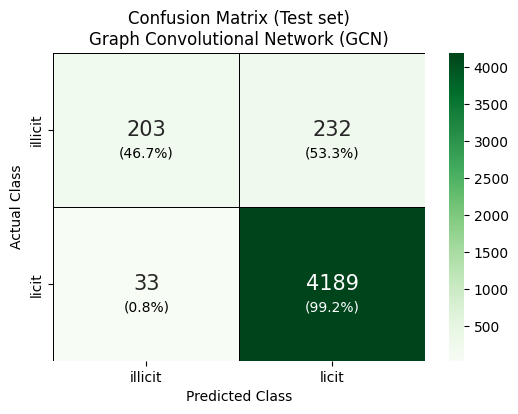

In [ ]:
mapped_classes = np.array(['illicit', 'licit'])

# --- Confusion matrix ---
cm = confusion_matrix(data.y[data.test_mask].cpu(), test_pred.cpu())

fig, ax = plt.subplots(figsize=(6, 4))

sns.heatmap(cm, annot=True, fmt='g', cmap=plt.cm.Greens,
            annot_kws={'size': 15},
            xticklabels=mapped_classes,
            yticklabels=mapped_classes,
            linecolor='black', linewidth=0.5,
            ax=ax)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')

# Annotate each cell with the percentage of that row.
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        percentage = cm_normalized[i, j] * 100
        text = f'\n({percentage:.1f}%)'
        color = 'white' if percentage > 95 else 'black'
        ax.text(j + 0.5, i + 0.6, text,
                ha='center', va='center', fontsize=10, color=color)

plt.title('Confusion Matrix (Test set)\nGraph Convolutional Network (GCN)')
plt.show()

In [ ]:
train_probas = predict_probabilities(model, data)[data.train_mask]
test_probas = predict_probabilities(model, data)[data.test_mask]

In [ ]:
train_probas_illicit = train_probas[:, 1].cpu().numpy()
train_probas_illicit

array([1.        , 1.        , 0.92797613, ..., 0.9997478 , 0.9945425 ,
       0.8790683 ], dtype=float32)

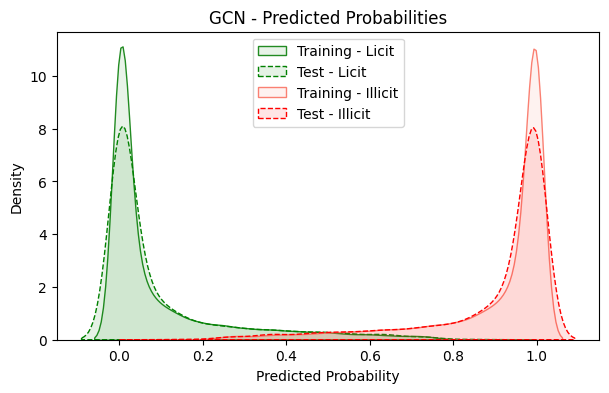

In [ ]:
ALPHA = 0.1

train_probas_licit = train_probas[:, 0].cpu().numpy()
train_probas_illicit = train_probas[:, 1].cpu().numpy()

test_probas_licit = test_probas[:, 0].cpu().numpy()
test_probas_illicit = test_probas[:, 1].cpu().numpy()

metrics_per_gnn['gcn']['test']['licit']['probas'] = test_probas_licit
metrics_per_gnn['gcn']['test']['illicit']['probas'] = test_probas_illicit

# -------- #
# Plotting #
# -------- #

plt.figure(figsize=(7, 4))

# Plot licit class probabilities
sns.kdeplot(train_probas_licit, fill=True, color="forestgreen", linestyle='-', alpha=ALPHA, label="Training - Licit")
sns.kdeplot(test_probas_licit, fill=True, color="green", linestyle='--', alpha=ALPHA, label="Test - Licit")

# Plot illicit class probabilities
sns.kdeplot(train_probas_illicit, fill=True, color="salmon", linestyle='-', alpha=ALPHA, label="Training - Illicit")
sns.kdeplot(test_probas_illicit, fill=True, color="red", linestyle='--', alpha=ALPHA, label="Test - Illicit")

plt.title("GCN - Predicted Probabilities")
plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.legend(loc="upper center")

plt.show()

In [ ]:
class GAT(torch.nn.Module):
    def __init__(self, num_node_features, num_classes, num_heads=8):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_node_features, 8, heads=num_heads, dropout=0.6)
        self.conv2 = GATConv(8 * num_heads, num_classes, heads=1, concat=False, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# ---------- #
# Initialize #
# ---------- #

model = GAT(num_node_features=data.num_features, num_classes=len(le.classes_)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0005)
criterion = torch.nn.CrossEntropyLoss()  # Since we have a multiclass classification problem.

data = data.to(device)

In [ ]:
train_val_metrics = train_gnn(NUM_EPOCHS,
                              data,
                              model,
                              optimizer,
                              criterion)

metrics_per_gnn['gat']['val']['precisions'] = train_val_metrics['val']['precisions']

Epoch 010, Loss: 0.7418, Train - Acc: 0.8829 - Prec: 0.8604 - Rec: 0.8829 - F1: 0.8697
                         Val   - Acc: 0.8870 - Prec: 0.8849 - Rec: 0.8870 - F1: 0.8859
Epoch 020, Loss: 0.5801, Train - Acc: 0.9007 - Prec: 0.8759 - Rec: 0.9007 - F1: 0.8825
                         Val   - Acc: 0.8671 - Prec: 0.8961 - Rec: 0.8671 - F1: 0.8783
Epoch 030, Loss: 0.5089, Train - Acc: 0.9085 - Prec: 0.8865 - Rec: 0.9085 - F1: 0.8859
                         Val   - Acc: 0.8920 - Prec: 0.9103 - Rec: 0.8920 - F1: 0.8991
Epoch 040, Loss: 0.4448, Train - Acc: 0.9140 - Prec: 0.8995 - Rec: 0.9140 - F1: 0.8904
                         Val   - Acc: 0.9132 - Prec: 0.9163 - Rec: 0.9132 - F1: 0.9147
Epoch 050, Loss: 0.4174, Train - Acc: 0.9157 - Prec: 0.9029 - Rec: 0.9157 - F1: 0.8931
                         Val   - Acc: 0.9328 - Prec: 0.9301 - Rec: 0.9328 - F1: 0.9312
Epoch 060, Loss: 0.3840, Train - Acc: 0.9178 - Prec: 0.9069 - Rec: 0.9178 - F1: 0.8964
                         Val   - Acc: 0.937

In [ ]:
model.eval()
with torch.no_grad():

    test_metrics = evaluate(model, data, data.test_mask)
    test_acc = test_metrics.get('accuracy')
    test_prec = test_metrics.get('precision')
    test_rec = test_metrics.get('recall')
    test_f1 = test_metrics.get('f1_score')

    print(f'Test Acc: {test_acc:.4f} - Prec: {test_prec:.4f} - Rec: {test_rec:.4f} - F1: {test_f1:.4f}')

Test Acc: 0.9435 - Prec: 0.9403 - Rec: 0.9435 - F1: 0.9355


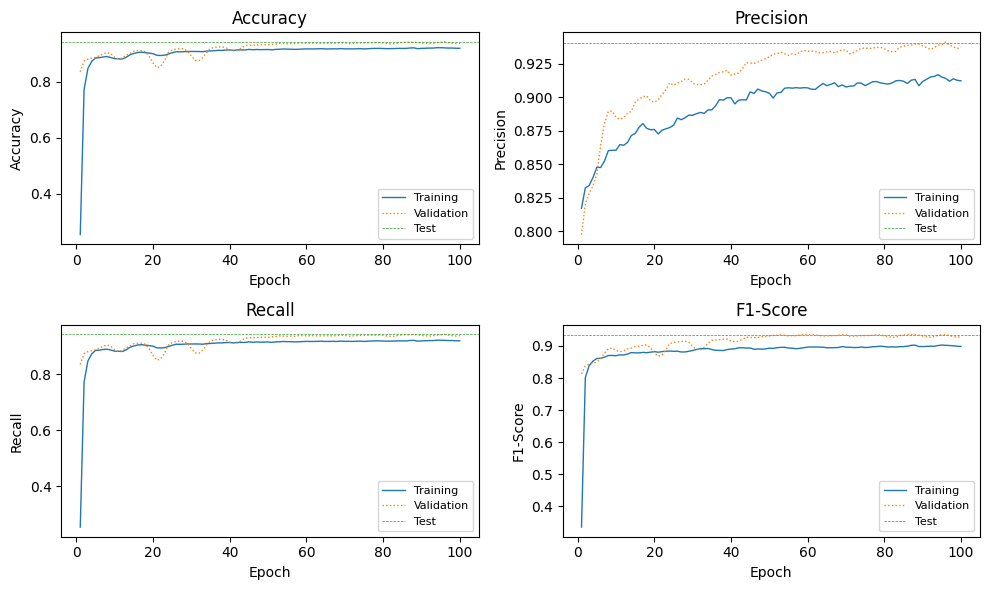

In [ ]:
plot_train_val_test_metrics(train_val_metrics, test_metrics, NUM_EPOCHS)

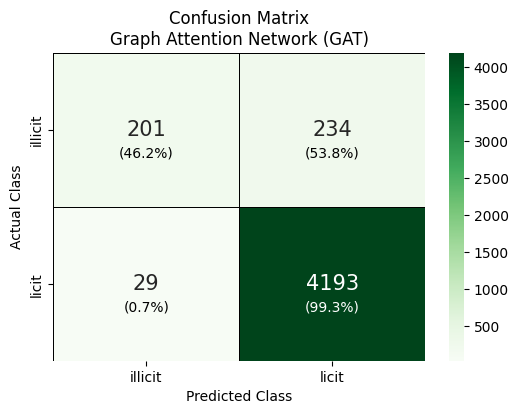

In [ ]:
test_pred = predict(model, data)[data.test_mask]

# --- Confusion matrix ---
cm = confusion_matrix(data.y[data.test_mask].cpu(), test_pred.cpu())

fig, ax = plt.subplots(figsize=(6, 4))

sns.heatmap(cm, annot=True, fmt='g', cmap=plt.cm.Greens,
            annot_kws={'size': 15},
            xticklabels=mapped_classes,
            yticklabels=mapped_classes,
            linecolor='black', linewidth=0.5,
            ax=ax)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')

# Annotate each cell with the percentage of that row.
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        percentage = cm_normalized[i, j] * 100
        text = f'\n({percentage:.1f}%)'
        color = 'white' if percentage > 95 else 'black'
        ax.text(j + 0.5, i + 0.6, text,
                ha='center', va='center', fontsize=10, color=color)

plt.title('Confusion Matrix\nGraph Attention Network (GAT)')
plt.show()

In [ ]:
train_probas = predict_probabilities(model, data)[data.train_mask]
test_probas = predict_probabilities(model, data)[data.test_mask]

In [ ]:
train_probas_illicit = train_probas[:, 1].cpu().numpy()
train_probas_illicit

array([0.9837123 , 0.99037147, 0.9277146 , ..., 0.9998043 , 0.9759858 ,
       0.70297015], dtype=float32)

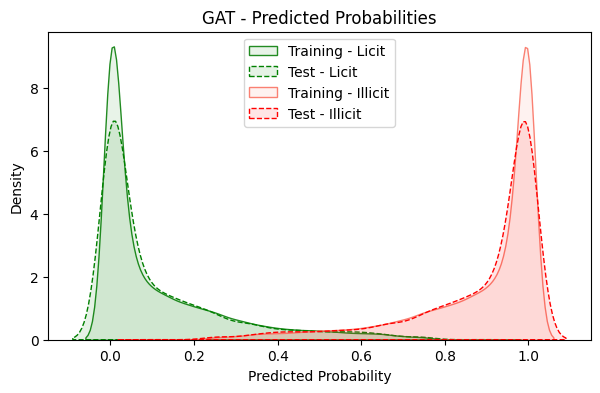

In [ ]:
ALPHA = 0.1

train_probas_licit = train_probas[:, 0].cpu().numpy()
train_probas_illicit = train_probas[:, 1].cpu().numpy()

test_probas_licit = test_probas[:, 0].cpu().numpy()
test_probas_illicit = test_probas[:, 1].cpu().numpy()

metrics_per_gnn['gat']['test']['licit']['probas'] = test_probas_licit
metrics_per_gnn['gat']['test']['illicit']['probas'] = test_probas_illicit

# -------- #
# Plotting #
# -------- #

plt.figure(figsize=(7, 4))

# Plot licit class probabilities
sns.kdeplot(train_probas_licit, fill=True, color="forestgreen", linestyle='-', alpha=ALPHA, label="Training - Licit")
sns.kdeplot(test_probas_licit, fill=True, color="green", linestyle='--', alpha=ALPHA, label="Test - Licit")

# Plot illicit class probabilities
sns.kdeplot(train_probas_illicit, fill=True, color="salmon", linestyle='-', alpha=ALPHA, label="Training - Illicit")
sns.kdeplot(test_probas_illicit, fill=True, color="red", linestyle='--', alpha=ALPHA, label="Test - Illicit")

plt.title("GAT - Predicted Probabilities")
plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.legend(loc="upper center")

plt.show()

In [ ]:
from torch_geometric.nn import GINConv, global_add_pool
import torch.nn.functional as F

class GIN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GIN, self).__init__()

        # 1st GIN layer.
        nn1 = torch.nn.Sequential(
            torch.nn.Linear(num_node_features, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64)
        )
        self.conv1 = GINConv(nn1)

        # 2nd GIN layer.
        nn2 = torch.nn.Sequential(
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64)
        )
        self.conv2 = GINConv(nn2)
        self.fc = torch.nn.Linear(64, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
#         x = global_add_pool(x, batch)
        x = self.fc(x)

        return F.log_softmax(x, dim=1)

# ---------- #
# Initialize #
# ---------- #

model = GIN(num_node_features=data.num_features, num_classes=len(le.classes_)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0005)
criterion = torch.nn.CrossEntropyLoss()

# # Handle the class imbalance
# class_counts = torch.bincount(data.y)
# class_weights = 1. / class_counts.float()
# criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

data = data.to(device)
# ----- #

In [ ]:
train_val_metrics = train_gnn(NUM_EPOCHS,
                              data,
                              model,
                              optimizer,
                              criterion)

metrics_per_gnn['gin']['val']['precisions'] = train_val_metrics['val']['precisions']

Epoch 010, Loss: 0.4180, Train - Acc: 0.9033 - Prec: 0.8160 - Rec: 0.9033 - F1: 0.8574
                         Val   - Acc: 0.8909 - Prec: 0.7937 - Rec: 0.8909 - F1: 0.8395
Epoch 020, Loss: 0.2733, Train - Acc: 0.9033 - Prec: 0.8160 - Rec: 0.9033 - F1: 0.8574
                         Val   - Acc: 0.8909 - Prec: 0.7937 - Rec: 0.8909 - F1: 0.8395
Epoch 030, Loss: 0.2446, Train - Acc: 0.9033 - Prec: 0.8643 - Rec: 0.9033 - F1: 0.8575
                         Val   - Acc: 0.8909 - Prec: 0.7937 - Rec: 0.8909 - F1: 0.8395
Epoch 040, Loss: 0.2077, Train - Acc: 0.9090 - Prec: 0.8894 - Rec: 0.9090 - F1: 0.8793
                         Val   - Acc: 0.9008 - Prec: 0.8835 - Rec: 0.9008 - F1: 0.8716
Epoch 050, Loss: 0.1633, Train - Acc: 0.9446 - Prec: 0.9406 - Rec: 0.9446 - F1: 0.9414
                         Val   - Acc: 0.9442 - Prec: 0.9409 - Rec: 0.9442 - F1: 0.9414
Epoch 060, Loss: 0.1307, Train - Acc: 0.9533 - Prec: 0.9505 - Rec: 0.9533 - F1: 0.9502
                         Val   - Acc: 0.951

In [ ]:
model.eval()
with torch.no_grad():

    test_metrics = evaluate(model, data, data.test_mask)
    test_acc = test_metrics.get('accuracy')
    test_prec = test_metrics.get('precision')
    test_rec = test_metrics.get('recall')
    test_f1 = test_metrics.get('f1_score')

    print(f'Test Acc: {test_acc:.4f} - Prec: {test_prec:.4f} - Rec: {test_rec:.4f} - F1: {test_f1:.4f}')

Test Acc: 0.9678 - Prec: 0.9666 - Rec: 0.9678 - F1: 0.9667


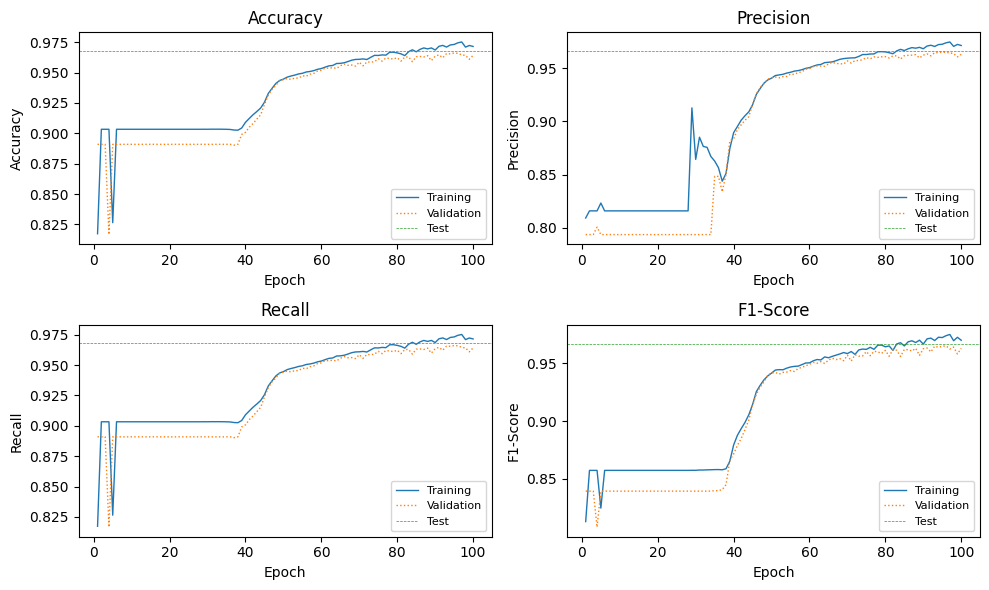

In [ ]:
plot_train_val_test_metrics(train_val_metrics, test_metrics, NUM_EPOCHS)

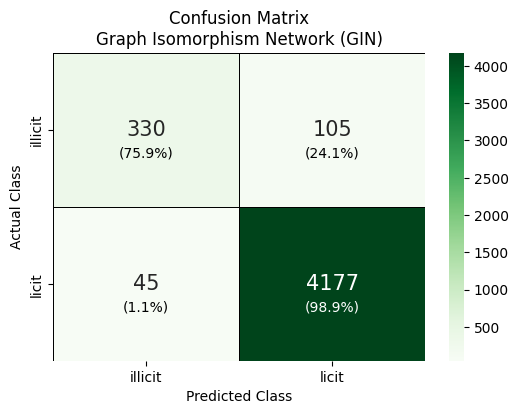

In [ ]:
test_pred = predict(model, data)[data.test_mask]

# --- Confusion matrix ---
cm = confusion_matrix(data.y[data.test_mask].cpu(), test_pred.cpu())

fig, ax = plt.subplots(figsize=(6, 4))

sns.heatmap(cm, annot=True, fmt='g', cmap=plt.cm.Greens,
            annot_kws={'size': 15},
            xticklabels=mapped_classes,
            yticklabels=mapped_classes,
            linecolor='black', linewidth=0.5,
            ax=ax)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')

# Annotate each cell with the percentage of that row.
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        percentage = cm_normalized[i, j] * 100
        text = f'\n({percentage:.1f}%)'
        color = 'white' if percentage > 95 else 'black'
        ax.text(j + 0.5, i + 0.6, text,
                ha='center', va='center', fontsize=10, color=color)

plt.title('Confusion Matrix\nGraph Isomorphism Network (GIN)')
plt.show()

In [ ]:
train_probas = predict_probabilities(model, data)[data.train_mask]
test_probas = predict_probabilities(model, data)[data.test_mask]

In [ ]:
train_probas_illicit = train_probas[:, 1].cpu().numpy()
train_probas_illicit

array([1.        , 1.        , 0.9909508 , ..., 0.9956002 , 0.99272716,
       0.83038884], dtype=float32)

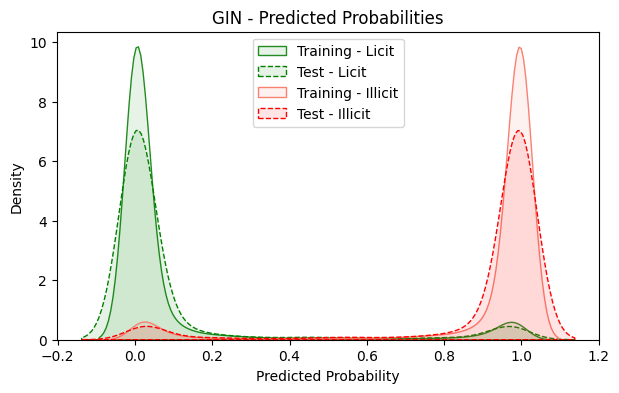

In [ ]:
ALPHA = 0.1

train_probas_licit = train_probas[:, 0].cpu().numpy()
train_probas_illicit = train_probas[:, 1].cpu().numpy()

test_probas_licit = test_probas[:, 0].cpu().numpy()
test_probas_illicit = test_probas[:, 1].cpu().numpy()

metrics_per_gnn['gin']['test']['licit']['probas'] = test_probas_licit
metrics_per_gnn['gin']['test']['illicit']['probas'] = test_probas_illicit

# -------- #
# Plotting #
# -------- #

plt.figure(figsize=(7, 4))

# Plot licit class probabilities
sns.kdeplot(train_probas_licit, fill=True, color="forestgreen", linestyle='-', alpha=ALPHA, label="Training - Licit")
sns.kdeplot(test_probas_licit, fill=True, color="green", linestyle='--', alpha=ALPHA, label="Test - Licit")

# Plot illicit class probabilities
sns.kdeplot(train_probas_illicit, fill=True, color="salmon", linestyle='-', alpha=ALPHA, label="Training - Illicit")
sns.kdeplot(test_probas_illicit, fill=True, color="red", linestyle='--', alpha=ALPHA, label="Test - Illicit")

plt.title("GIN - Predicted Probabilities")
plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.legend(loc="upper center")

plt.show()

In [ ]:
from sklearn.manifold import TSNE
from cuml.manifold import TSNE as cuTSNE
from sklearn.decomposition import PCA

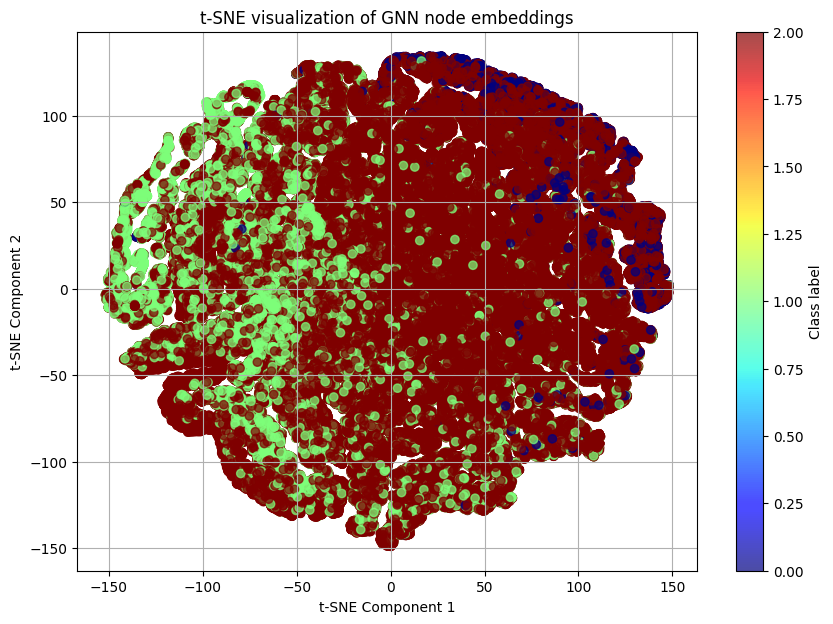

In [ ]:
model.eval()
with torch.no_grad():
    embeddings = model(data)  # Pass the whole data object

# Reduce dimensions with PCA
pca = PCA(n_components=2, random_state=42)
embeddings_pca = pca.fit_transform(embeddings.cpu().numpy())

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings_pca)

# Plotting
plt.figure(figsize=(10, 7))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=data.y.cpu().numpy(), cmap="jet", alpha=0.7)
plt.colorbar(scatter, label='Class label')
plt.title("t-SNE visualization of GNN node embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.grid(True)
plt.show()



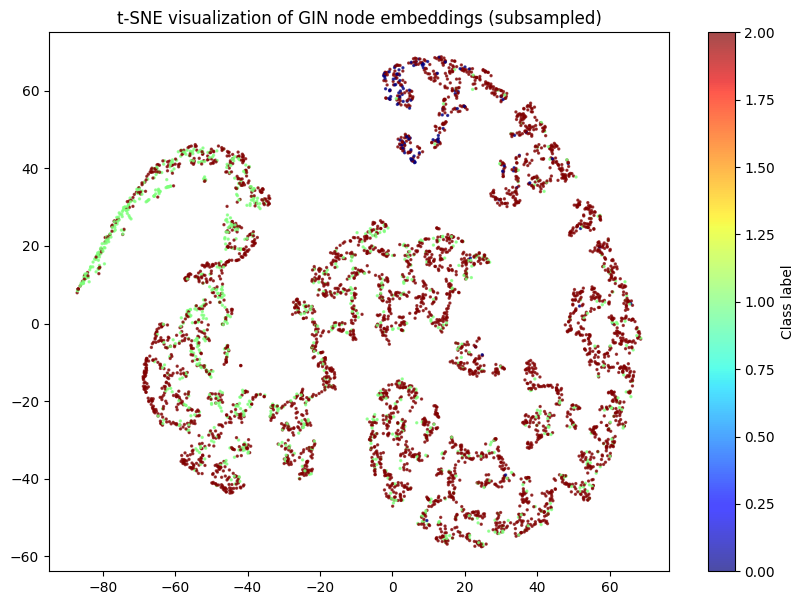

In [ ]:
subset_size = 5_000
indices = np.random.choice(len(embeddings), subset_size, replace=False)
embeddings_subset = embeddings[indices]
labels_subset = data.y.cpu().numpy()[indices]

tsne = TSNE(n_components=2, random_state=RANDOM_STATE)
embeddings_2d = tsne.fit_transform(embeddings_subset)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=2, c=labels_subset, cmap="jet", alpha=0.7)
plt.colorbar(scatter, label='Class label')
plt.title("t-SNE visualization of GIN node embeddings (subsampled)")
plt.show()

In [ ]:
!pip install openTSNE



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 22.1 MB/s eta 0:00:00


In [ ]:
from openTSNE import TSNE

embeddings_np = embeddings.detach().cpu().numpy()
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = tsne.fit(embeddings_np)

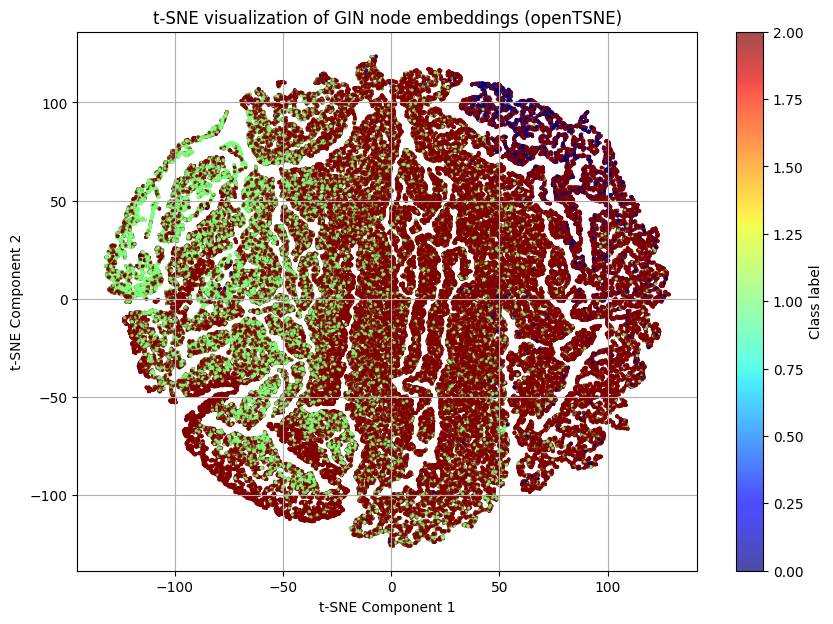

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=2,
                      c=data.y.cpu().numpy(), cmap="jet", alpha=0.7)
plt.colorbar(scatter, label='Class label')
plt.title("t-SNE visualization of GIN node embeddings (openTSNE)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.grid(True)
plt.show()


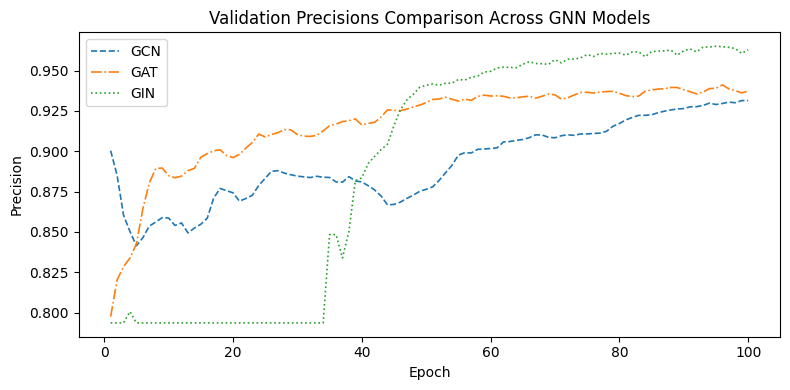

In [ ]:
plt.figure(figsize=(8, 4))

epochs = range(1, len(metrics_per_gnn['gcn']['val']['precisions']) + 1)

plt.plot(epochs, metrics_per_gnn['gcn']['val']['precisions'], color='C0', linewidth=1.2, linestyle='--', label='GCN')
plt.plot(epochs, metrics_per_gnn['gat']['val']['precisions'], color='C1', linewidth=1.2, linestyle='-.', label='GAT')
plt.plot(epochs, metrics_per_gnn['gin']['val']['precisions'], color='C2', linewidth=1.2, linestyle=':', label='GIN')

plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Validation Precisions Comparison Across GNN Models')
plt.legend(fontsize=10)
plt.grid(False)
plt.tight_layout()
plt.show()

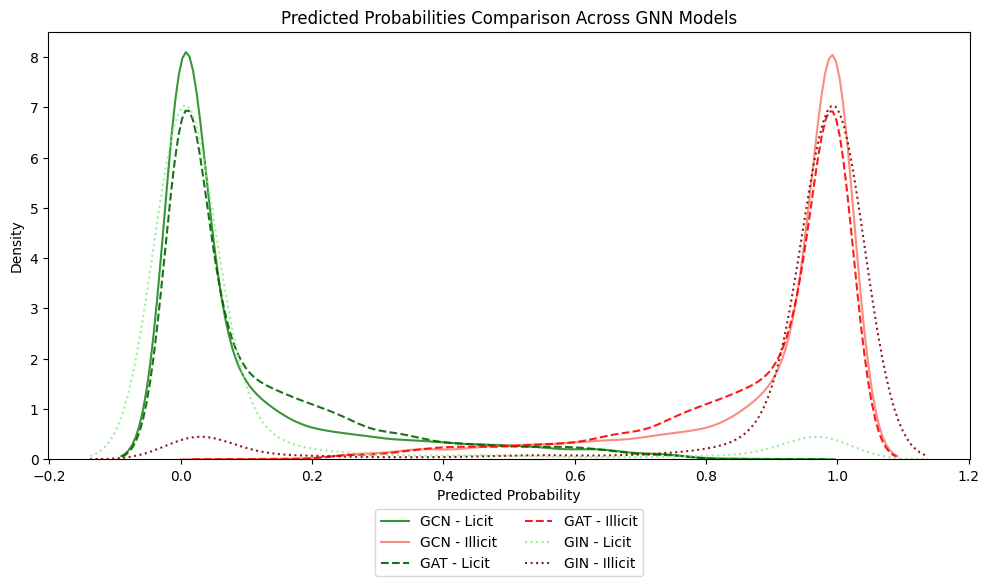

In [ ]:
ALPHA = 0.9
FILL = False

plt.figure(figsize=(10, 6))

sns.kdeplot(metrics_per_gnn['gcn']['test']['licit']['probas'], fill=FILL, color="forestgreen", linestyle='-', alpha=ALPHA, label="GCN - Licit")
sns.kdeplot(metrics_per_gnn['gcn']['test']['illicit']['probas'], fill=FILL, color="salmon", linestyle='-', alpha=ALPHA, label="GCN - Illicit")

sns.kdeplot(metrics_per_gnn['gat']['test']['licit']['probas'], fill=FILL, color="darkgreen", linestyle='--', alpha=ALPHA, label="GAT - Licit")
sns.kdeplot(metrics_per_gnn['gat']['test']['illicit']['probas'], fill=FILL, color="red", linestyle='--', alpha=ALPHA, label="GAT - Illicit")

sns.kdeplot(metrics_per_gnn['gin']['test']['licit']['probas'], fill=FILL, color="lightgreen", linestyle=':', alpha=ALPHA, label="GIN - Licit")
sns.kdeplot(metrics_per_gnn['gin']['test']['illicit']['probas'], fill=FILL, color="darkred", linestyle=':', alpha=ALPHA, label="GIN - Illicit")

plt.title("Predicted Probabilities Comparison Across GNN Models")
plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.tight_layout()

plt.show()

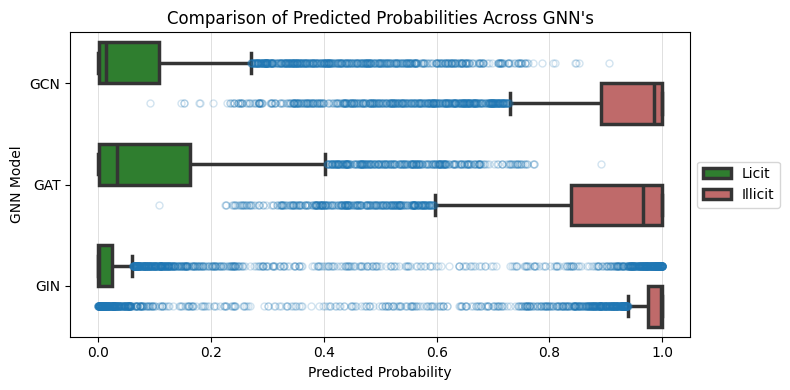

In [ ]:
data_temp = []

for model in ['gcn', 'gat', 'gin']:
    for category in ['licit', 'illicit']:
        probas = metrics_per_gnn[model]['test'][category]['probas']
        data_temp.extend([(model.upper(), category.capitalize(), proba) for proba in probas])

temp = pd.DataFrame(data_temp, columns=['Model', 'Class', 'Probability'])

plt.figure(figsize=(8, 4))

flierprops = dict(marker='o', markerfacecolor='None', markersize=5,  markeredgecolor='C0', alpha=0.2)

ax = sns.boxplot(y='Model', x='Probability', hue='Class', data=temp,
                 linewidth=2.5,
                 fliersize=0.5,
                 palette={
                     'Licit': 'forestgreen',
                     'Illicit': 'indianred'
                 },
                 flierprops=flierprops
)


plt.grid(True, which='both', axis='x', color='lightgrey', linestyle='-', linewidth=0.5)
plt.title("Comparison of Predicted Probabilities Across GNN's")
plt.xlabel("Predicted Probability")
plt.ylabel("GNN Model")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), ncol=1)
plt.tight_layout()
plt.show()

In [ ]:
comparisons = [('gcn', 'gat'), ('gcn', 'gin'), ('gat', 'gin')]
results = []

for model1, model2 in comparisons:
    for category in ['licit', 'illicit']:
        probas1 = metrics_per_gnn[model1]['test'][category]['probas']
        probas2 = metrics_per_gnn[model2]['test'][category]['probas']
        t_stat, p_val = ttest_ind(probas1, probas2, equal_var=False)
        if p_val < 0.05:
            results.append(f"Significant difference between {model1.upper()} and {model2.upper()} for {category.capitalize()} predictions (p-value: {p_val:.4f})")

for result in results:
    print(result)

Significant difference between GCN and GAT for Licit predictions (p-value: 0.0000)
Significant difference between GCN and GAT for Illicit predictions (p-value: 0.0000)
Significant difference between GAT and GIN for Licit predictions (p-value: 0.0001)
Significant difference between GAT and GIN for Illicit predictions (p-value: 0.0001)


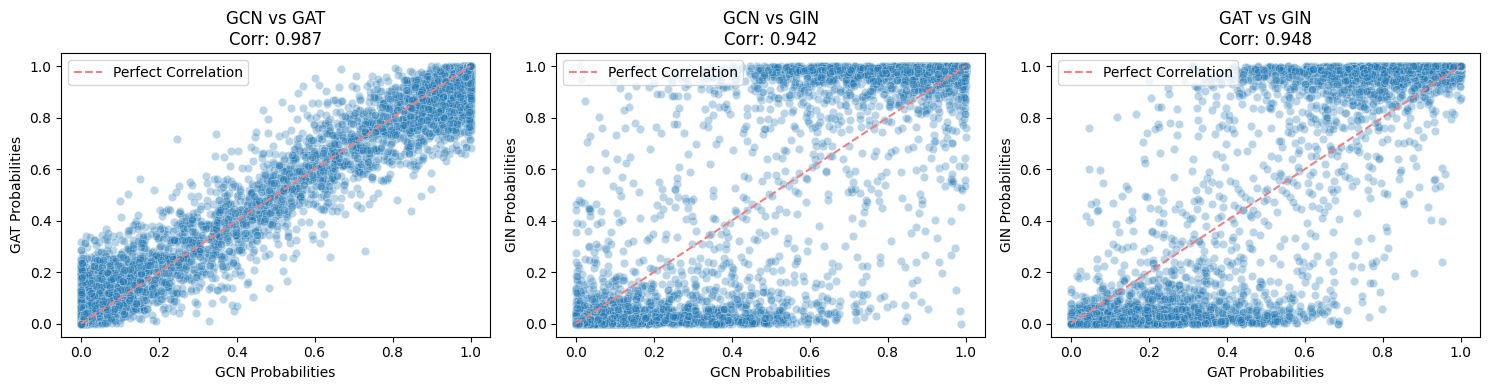

In [ ]:
combinations = [('GCN', 'GAT'), ('GCN', 'GIN'), ('GAT', 'GIN')]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (model1, model2) in zip(axes, combinations):
    scatter_data = pd.DataFrame({
        f'{model1}_Probabilities': temp[temp['Model'] == model1]['Probability'].values,
        f'{model2}_Probabilities': temp[temp['Model'] == model2]['Probability'].values
    })

    sns.scatterplot(
        data=scatter_data,
        x=f'{model1}_Probabilities',
        y=f'{model2}_Probabilities',
        color='C0',
        edgecolor='white',
        marker='o',
        alpha=0.3, ax=ax
    )

    corr_value = np.corrcoef(temp[temp['Model'] == model1]['Probability'],
                             temp[temp['Model'] == model2]['Probability'])[0, 1]

    ax.plot([0, 1], [0, 1], ls='--', color='lightcoral', label=f'Perfect Correlation', alpha=1.0)

    ax.set_title(f'{model1} vs {model2}\nCorr: {corr_value:.3f}')
    ax.set_xlabel(f'{model1} Probabilities')
    ax.set_ylabel(f'{model2} Probabilities')
    ax.legend(loc='upper left')

plt.tight_layout()
plt.show()